# Lab 5

Daniel Alfredo Rayo Roldan

Gerardo Gabriel Pineda Riveiro

https://github.com/DanielRasho/DS-lab6

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords as nltk_stop
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import warnings
from textblob import TextBlob
import requests
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
warnings.filterwarnings('ignore')

In [26]:
df_train = pd.read_csv("./data/train.csv")

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [27]:
print(f"Número de filas: {df_train.shape[0]}")
print(f"Número de columnas: {df_train.shape[1]}")
print(f"\nColumnas: {list(df_train.columns)}")
print(f"\nTipos de datos:")
df_train.dtypes

Número de filas: 7613
Número de columnas: 5

Columnas: ['id', 'keyword', 'location', 'text', 'target']

Tipos de datos:


id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

## Análisis Exploratorio

### Valores faltantes

In [28]:
missing_values = df_train.isnull().sum()
missing_percent = (missing_values / len(df_train)) * 100

missing_df = pd.DataFrame({
    'Columna': missing_values.index,
    'Valores Faltantes': missing_values.values,
    'Porcentaje': missing_percent.values
})
missing_df

,Columna,Valores Faltantes,Porcentaje
0,id,0,0.000000
1,keyword,61,0.801261
2,location,2533,33.272035
3,text,0,0.000000
4,target,0,0.000000


### Distribución de variable objetivo

Tweets NO desastre (0): 4342 (57.0%)
Tweets de desastre (1): 3271 (43.0%)


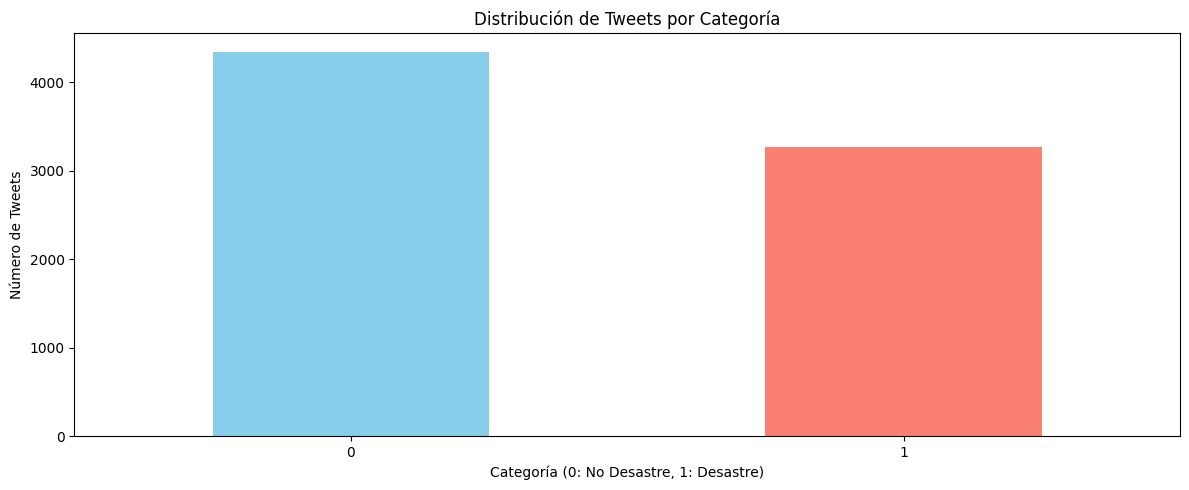

In [29]:
# Distribución de la variable objetivo
target_counts = df_train['target'].value_counts()
print(f"Tweets NO desastre (0): {target_counts[0]} ({target_counts[0]/len(df_train)*100:.1f}%)")
print(f"Tweets de desastre (1): {target_counts[1]} ({target_counts[1]/len(df_train)*100:.1f}%)")

# Visualización de la distribución
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 5))

# Gráfico de barras
target_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Distribución de Tweets por Categoría')
ax1.set_xlabel('Categoría (0: No Desastre, 1: Desastre)')
ax1.set_ylabel('Número de Tweets')
ax1.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [30]:
# Ejemplos de tweets por categoría
print("\n=== EJEMPLOS DE TWEETS ===")
print("Tweets de DESASTRE:")
for i, tweet in enumerate(df_train[df_train['target']==1]['text'].head(3)):
    print(f"{i+1}. {tweet}")

print("\nTweets NO de desastre:")
for i, tweet in enumerate(df_train[df_train['target']==0]['text'].head(3)):
    print(f"{i+1}. {tweet}")


=== EJEMPLOS DE TWEETS ===
Tweets de DESASTRE:
1. Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
2. Forest fire near La Ronge Sask. Canada
3. All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected

Tweets NO de desastre:
1. What's up man?
2. I love fruits
3. Summer is lovely


# Preprocesamiento

Se descargan las stopword del paquete de nltk y se crea el tokenizador de tweets de la libreria nltk.

In [31]:
nltk.download("stopwords"); nltk.download("wordnet"); nltk.download("omw-1.4")
tt = TweetTokenizer(preserve_case=not True, reduce_len=True, strip_handles=False)
wnl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/smaug/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/smaug/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/smaug/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Como el idioma del set es ingles se obtienen los stopwords en este idio y nos aseguramos que las palabras negativas que se queden porque estas son valiosas para el analiss

In [32]:
stopwords = set(nltk_stop.words("english"))
negs = {"no","not","n't"}
stopwords = {w for w in stopwords if w.lower() not in negs}

Se crean expresiones regualres especificas para cada parte de la limpieza que se quiere quitar.

In [33]:
URL_RE = re.compile(r"(https?://\S+|www\.\S+)")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
APOSTROPHES_RE = re.compile(r"[’`´]")
EMOJI_RE = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002702-\U000027B0"
    "\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE
)
NUMBER_RE = re.compile(r"\b\d+(?:[.,]\d+)*\b")

PUNCT_TABLE = str.maketrans("", "", string.punctuation)

Se crea una funcion donde se mapean todas las palabras y se quita lo siguiente:
- Se convirtio todo a minusculas.
- Se quitar los caracteres especiales que aparecen como *#*, *@* o los *apostrofes*
- Se quitar las url
- Se decidio quitar los emojis pero se quedo con una flag por si se quieren dejar.
- Se quitaron los signos de puntuación.
- Se quitaron las stopwords
- Se quitaron los numeros menos el 911

In [34]:
def remove_non_ascii(text: str) -> str:
    return re.sub(r"[^\x00-\x7F]+", " ", text)

def count_pattern(pat, text):
    return len(pat.findall(text))

def clean_raw(text: str) -> dict:
    original = text

    
    text = text.lower()

    urls = mentions = emojis = hashtags = numbers = 0

    urls = count_pattern(URL_RE, text)
    text = URL_RE.sub(" ", text)

    mentions = count_pattern(MENTION_RE, text)
    text = MENTION_RE.sub(" ", text)

    hashtags = count_pattern(HASHTAG_RE, text)
    text = HASHTAG_RE.sub(lambda m: m.group(1), text)

    text = APOSTROPHES_RE.sub("'", text)

    if True: # Cambiar esto para cambiarlos emojis (si queres rayo)
        emojis = len(EMOJI_RE.findall(text))
        text = EMOJI_RE.sub(" ", text)

    # Aqui estan los numeros solo vamos a dejar el 911
    def num_filter(m):
        tok = m.group(0)
        return tok if tok in {"911"} else " "
    numbers = len(NUMBER_RE.findall(text))
    text = NUMBER_RE.sub(num_filter, text)

    text = text.translate(PUNCT_TABLE)

    text = remove_non_ascii(text)

    text = re.sub(r"\s+", " ", text).strip()

    return {
        "text_raw": original,
        "text_clean_raw": text,
        "urls_removed": urls,
        "mentions_removed": mentions,
        "emojis_removed": emojis,
        "hashtags_unhashed": hashtags,
        "numbers_affected": numbers
    }

clean_rows = df_train["text"].map(clean_raw)
clean_df = pd.DataFrame(list(clean_rows))
df_train = pd.concat([df_train, clean_df], axis=1)

In [35]:
def tokenize_and_normalize(text: str):
    tokens = []
    toks = tt.tokenize(text)
    toks = [t for t in toks if all(ch not in string.punctuation for ch in t)]
    toks = [wnl.lemmatize(t) for t in toks]
    # stopwords
    toks = [t for t in toks if t.lower() not in stopwords]
    tokens = toks

    tokens = [t.strip() for t in tokens if t.strip() != ""]
    return tokens

df_train["tokens"] = df_train["text_clean_raw"].map(tokenize_and_normalize)
df_train["text_clean"] = df_train["tokens"].map(lambda ts: " ".join(ts))

In [36]:
df_train["len_raw"] = df_train["text"].str.split().map(len)
df_train["len_clean"] = df_train["tokens"].map(len)

In [37]:
print(df_train[["text_clean_raw","tokens","text_clean"]].head(1))

                                      text_clean_raw  \
0  our deeds are the reason of this earthquake ma...   

                                              tokens  \
0  [deed, reason, earthquake, may, allah, forgive...   

                                   text_clean  
0  deed reason earthquake may allah forgive u  


### Frecuencia de palabras por categoría

In [38]:
# Separar textos por categoría
disaster_tweets = df_train[df_train['target'] == 1]['text_clean']
non_disaster_tweets = df_train[df_train['target'] == 0]['text_clean']

# Función para obtener frecuencias de palabras
def get_word_frequencies(texts, top_n=20):
    """
    Obtiene las palabras más frecuentes de una lista de textos
    """
    all_words = []
    for text in texts:
        words = text.split()
        all_words.extend(words)
    
    return Counter(all_words).most_common(top_n)

# Obtener palabras más frecuentes para cada categoría
disaster_freq = get_word_frequencies(disaster_tweets)
non_disaster_freq = get_word_frequencies(non_disaster_tweets)

print("TOP 20 PALABRAS MÁS FRECUENTES - TWEETS DE DESASTRE:")
for word, freq in disaster_freq:
    print(f"{word}: {freq}")

print("\nTOP 20 PALABRAS MÁS FRECUENTES - TWEETS NO DE DESASTRE:")
for word, freq in non_disaster_freq:
    print(f"{word}: {freq}")

TOP 20 PALABRAS MÁS FRECUENTES - TWEETS DE DESASTRE:
fire: 265
wa: 174
news: 136
via: 121
disaster: 117
california: 115
suicide: 110
amp: 109
no: 108
police: 107
people: 106
u: 105
family: 105
ha: 105
home: 101
train: 100
building: 95
not: 93
killed: 93
like: 92

TOP 20 PALABRAS MÁS FRECUENTES - TWEETS NO DE DESASTRE:
like: 255
im: 244
wa: 219
not: 204
amp: 193
get: 185
new: 171
ha: 152
no: 146
u: 146
dont: 141
one: 137
body: 117
time: 104
video: 102
via: 99
would: 97
day: 96
love: 95
people: 92


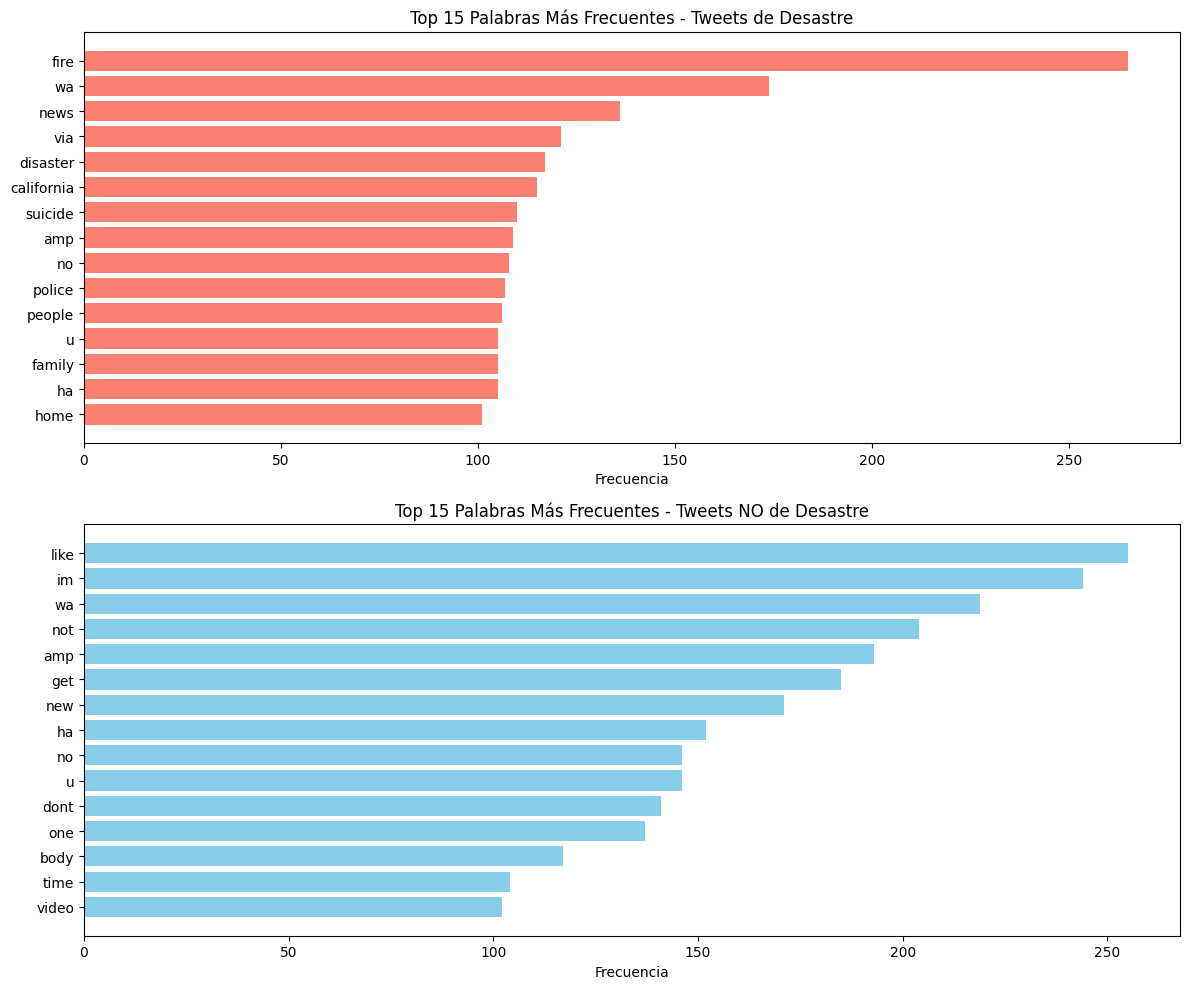

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Palabras más frecuentes en tweets de desastre
disaster_words = [word for word, freq in disaster_freq]
disaster_counts = [freq for word, freq in disaster_freq]

ax1.barh(disaster_words[:15][::-1], disaster_counts[:15][::-1], color='salmon')
ax1.set_title('Top 15 Palabras Más Frecuentes - Tweets de Desastre')
ax1.set_xlabel('Frecuencia')

# Palabras más frecuentes en tweets NO de desastre
non_disaster_words = [word for word, freq in non_disaster_freq]
non_disaster_counts = [freq for word, freq in non_disaster_freq]

ax2.barh(non_disaster_words[:15][::-1], non_disaster_counts[:15][::-1], color='skyblue')
ax2.set_title('Top 15 Palabras Más Frecuentes - Tweets NO de Desastre')
ax2.set_xlabel('Frecuencia')

plt.tight_layout()
plt.show()

### Analísis de Bigramas y Trigramas

#### Bigramas

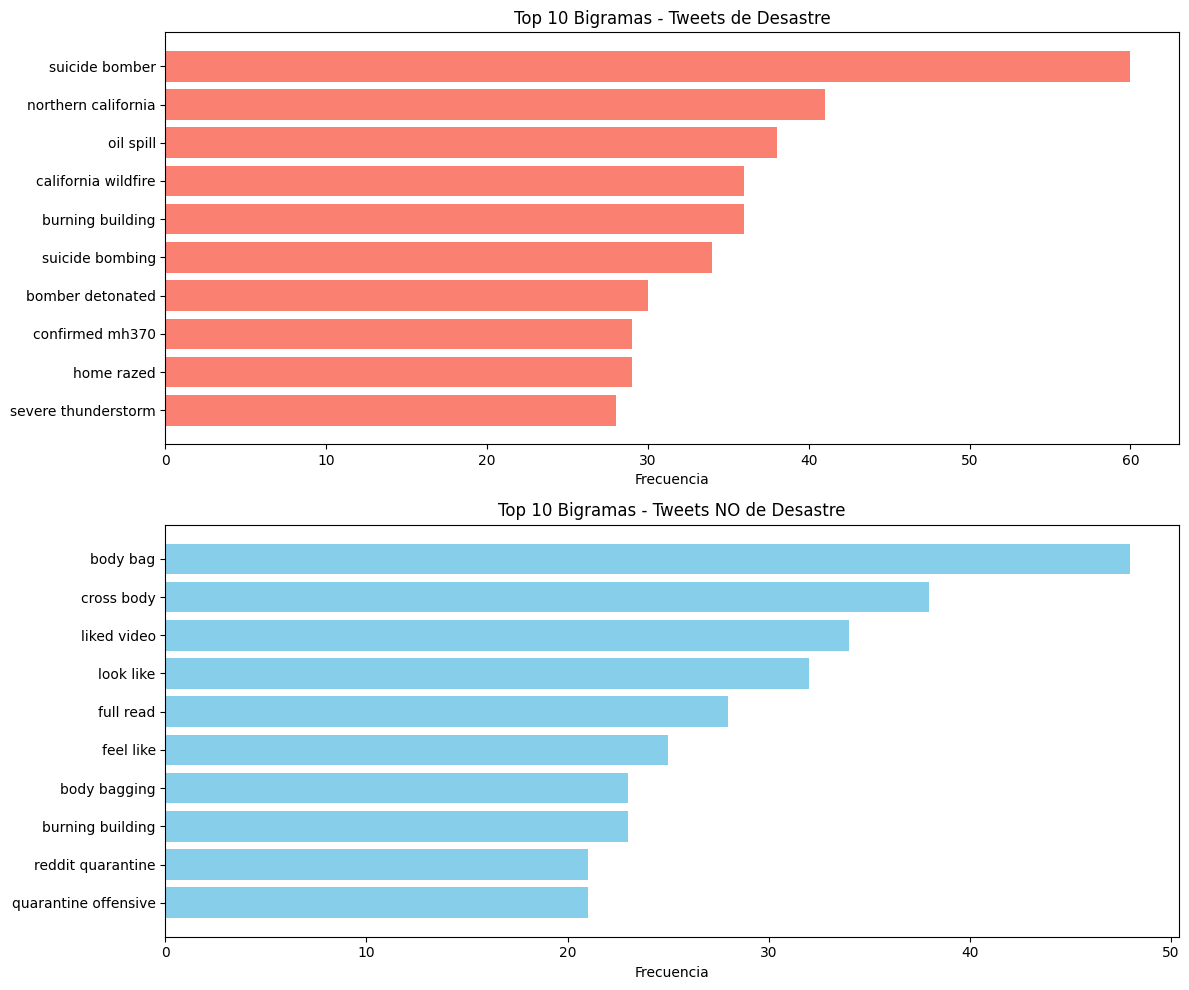

In [40]:
def get_ngrams(texts, n=2, top_n=15):
    """
    Obtiene los n-gramas más frecuentes
    """
    all_ngrams = []
    for text in texts:
        words = text.split()
        if len(words) >= n:
            text_ngrams = list(ngrams(words, n))
            all_ngrams.extend(text_ngrams)
    
    ngram_freq = Counter(all_ngrams)
    return ngram_freq.most_common(top_n)

# Obtener bigramas más frecuentes
disaster_bigrams = get_ngrams(disaster_tweets, n=2, top_n=15)
non_disaster_bigrams = get_ngrams(non_disaster_tweets, n=2, top_n=15)

# Visualización de bigramas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Bigramas de tweets de desastre
disaster_bigram_labels = [' '.join(bigram) for bigram, freq in disaster_bigrams]
disaster_bigram_counts = [freq for bigram, freq in disaster_bigrams]

ax1.barh(disaster_bigram_labels[:10][::-1], disaster_bigram_counts[:10][::-1], color='salmon')
ax1.set_title('Top 10 Bigramas - Tweets de Desastre')
ax1.set_xlabel('Frecuencia')

# Bigramas de tweets NO de desastre
non_disaster_bigram_labels = [' '.join(bigram) for bigram, freq in non_disaster_bigrams]
non_disaster_bigram_counts = [freq for bigram, freq in non_disaster_bigrams]

ax2.barh(non_disaster_bigram_labels[:10][::-1], non_disaster_bigram_counts[:10][::-1], color='skyblue')
ax2.set_title('Top 10 Bigramas - Tweets NO de Desastre')
ax2.set_xlabel('Frecuencia')

plt.tight_layout()
plt.show()


#### Trigramas

In [41]:
disaster_trigrams = get_ngrams(disaster_tweets, n=3, top_n=10)
non_disaster_trigrams = get_ngrams(non_disaster_tweets, n=3, top_n=10)

print("\nTOP 10 TRIGRAMAS - TWEETS DE DESASTRE:")
for trigram, freq in disaster_trigrams:
    print(f"{' '.join(trigram)}: {freq}")

print("\nTOP 10 TRIGRAMAS - TWEETS NO DE DESASTRE:")
for trigram, freq in non_disaster_trigrams:
    print(f"{' '.join(trigram)}: {freq}")


TOP 10 TRIGRAMAS - TWEETS DE DESASTRE:
suicide bomber detonated: 30
northern california wildfire: 29
latest home razed: 28
home razed northern: 28
pkk suicide bomber: 28
bomber detonated bomb: 28
razed northern california: 27
16yr old pkk: 27
old pkk suicide: 27
family sue legionnaire: 26

TOP 10 TRIGRAMAS - TWEETS NO DE DESASTRE:
cross body bag: 23
reddit quarantine offensive: 21
quarantine offensive content: 20
pick fan army: 17
reddits new content: 16
new content policy: 16
china stock market: 16
stock market crash: 16
full read ebay: 15
ignition knock detonation: 15


## Modelos de Clasificación de sentimientos

In [42]:
df_train

,id,keyword,location,text,target,text_raw,text_clean_raw,urls_removed,mentions_removed,emojis_removed,hashtags_unhashed,numbers_affected,tokens,text_clean,len_raw,len_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...,0,0,0,1,0,"[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u,13,7
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,0,0,0,0,0,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada,7,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,0,0,0,0,0,"[resident, asked, shelter, place, notified, of...",resident asked shelter place notified officer ...,22,12
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...,0,0,0,1,1,"[people, receive, wildfire, evacuation, order,...",people receive wildfire evacuation order calif...,8,6
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...,0,0,0,2,0,"[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...,16,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...,two giant cranes holding a bridge collapse int...,1,0,0,0,0,"[two, giant, crane, holding, bridge, collapse,...",two giant crane holding bridge collapse nearby...,11,8
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control w...,the out of control wild fires in california ev...,0,2,0,0,0,"[control, wild, fire, california, even, northe...",control wild fire california even northern par...,20,9
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,m1 utc5km s of volcano hawaii,1,0,0,0,3,"[m1, utc, 5km, volcano, hawaii]",m1 utc 5km volcano hawaii,8,5
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...,police investigating after an ebike collided w...,0,0,0,0,0,"[police, investigating, ebike, collided, car, ...",police investigating ebike collided car little...,19,14


### Modelo usando Vader

In [43]:
analyzer_vader = SentimentIntensityAnalyzer()

print("Aplicando VADER Sentiment...")

def analyze_vader_sentiment(text):
    """
    Analiza sentimiento con VADER
    """
    scores = analyzer_vader.polarity_scores(text)
    compound = scores['compound']
    
    if compound >= 0.00:
        return 0, compound, scores
    elif compound <= -0.00:
       return 1, compound, scores
    else:
        return 'neutral', compound, scores

vader_results = df_train['text_clean'].apply(analyze_vader_sentiment)
df_train['vader_sentiment'] = [r[0] for r in vader_results]
df_train['vader_compound'] = [r[1] for r in vader_results]


Aplicando VADER Sentiment...


### Modelo usando textblob

In [46]:
def analyze_textblob_sentiment(text):
    """
    Analiza sentimiento con TextBlob
    """
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    
    if polarity >= 0.0:
        return 0, polarity
    elif polarity < 0.0:
        return 1, polarity
    else:
        return 'neutral', polarity

textblob_results = df_train['text_clean'].apply(analyze_textblob_sentiment)
df_train['textblob_sentiment'] = [r[0] for r in textblob_results]
df_train['textblob_polarity'] = [r[1] for r in textblob_results]

In [47]:
df_train[["text_clean", "target", "vader_sentiment", "textblob_sentiment"]].head(100)

,text_clean,target,vader_sentiment,textblob_sentiment
0,deed reason earthquake may allah forgive u,1,0,0
1,forest fire near la ronge sask canada,1,1,0
2,resident asked shelter place notified officer ...,1,1,1
3,people receive wildfire evacuation order calif...,1,0,0
4,got sent photo ruby alaska smoke wildfire pour...,1,0,0
...,...,...,...,...
95,mile backup southaccident blocking right lane ...,1,1,0
96,ha accident changed life help determine option...,0,0,0
97,breaking wa deadly motorcycle car accident hap...,1,1,1
98,marinading wa accident,0,1,0


## Modelos de clasificación de palabras

In [ ]:
def download_afinn_lexicon():
    url = "https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-111.txt"
    try:
        response = requests.get(url)
        afinn_dict = {}
        
        for line in response.text.strip().split('\n'):
            word, score = line.split('\t')
            afinn_dict[word] = int(score)
        
        print(f"✓ AFINN léxico cargado: {len(afinn_dict)} palabras")
        return afinn_dict
    except Exception as e:
        print(f"Error descargando AFINN: {e}")
        return {}

afinn_lexicon = download_afinn_lexicon()

✓ AFINN léxico cargado: 2477 palabras


In [ ]:
def classify_word_sentiment(word):
    word_lower = word.lower().strip()
    return 'neutral', 0, 'none'

In [ ]:
def analyze_tweet_words(word_list):
    if not isinstance(word_list, list):
        return None
    
    word_analysis = []
    positive_words = []
    negative_words = []
    neutral_words = []
    
    total_positive_score = 0
    total_negative_score = 0
    
    for word in word_list:
        sentiment, score, source = classify_word_sentiment(word)
        
        word_info = {
            'word': word,
            'sentiment': sentiment,
            'score': score,
            'source': source
        }
        word_analysis.append(word_info)
        
        if sentiment == 'positive':
            positive_words.append(word)
            total_positive_score += score
        elif sentiment == 'negative':
            negative_words.append(word)
            total_negative_score += score
        else:
            neutral_words.append(word)
    
    positive_count = len(positive_words)
    negative_count = len(negative_words)
    
    net_score = total_positive_score - total_negative_score
    
    if positive_count > negative_count and positive_count > 0:
        tweet_sentiment = 'positive'
    elif negative_count > positive_count and negative_count > 0:
        tweet_sentiment = 'negative'
    elif net_score > 1:
        tweet_sentiment = 'positive'
    elif net_score < -1:
        tweet_sentiment = 'negative'
    else:
        tweet_sentiment = 'neutral'
    
    return {
        'word_analysis': word_analysis,
        'summary': {
            'tweet_sentiment': tweet_sentiment,
            'net_score': net_score,
            'negative_count': negative_count,
        }
    }

In [57]:
def analyze_dataframe_sentiment(df, words_column='words'):
    print(f"Analizando sentimiento de {len(df)} tweets...")
    
    results = []
    for i, word_list in enumerate(df[words_column]):
        if i % 1000 == 0:
            print(f"Procesando tweet {i}...")
        
        analysis = analyze_tweet_words(word_list)
        results.append(analysis)
    
    df = df.copy()
    
    df['net score'] = [r['summary']['net_score'] if r else 0 for r in results]
    df['overall sentiment'] = [r['summary']['tweet_sentiment'] if r else 0 for r in results]
    df['negative_count'] = [r['summary']['negative_count'] if r else 0 for r in results]
    return df

df_analyzed = analyze_dataframe_sentiment(df_train, "tokens")

Analizando sentimiento de 7613 tweets...
Procesando tweet 0...
Procesando tweet 1000...
Procesando tweet 2000...
Procesando tweet 3000...
Procesando tweet 4000...
Procesando tweet 5000...
Procesando tweet 6000...
Procesando tweet 7000...


In [59]:
df_analyzed[['id', 'text_clean' , 'net score', 'overall sentiment', 'negative_count']]

,id,text_clean,net score,overall sentiment,negative_count
0,1,deed reason earthquake may allah forgive u,1,positive,0
1,4,forest fire near la ronge sask canada,-2,negative,1
2,5,resident asked shelter place notified officer ...,-1,negative,1
3,6,people receive wildfire evacuation order calif...,0,neutral,0
4,7,got sent photo ruby alaska smoke wildfire pour...,0,neutral,0
...,...,...,...,...,...
7608,10869,two giant crane holding bridge collapse nearby...,-2,negative,1
7609,10870,control wild fire california even northern par...,-2,negative,1
7610,10871,m1 utc 5km volcano hawaii,0,neutral,0
7611,10872,police investigating ebike collided car little...,-4,negative,2


# Conclusiones